In [1]:
import random

import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_x = mnist.train.images
train_y = mnist.train.labels

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

idx = np.argsort(train_y)
train_x = train_x[idx]
train_y = train_y[idx]

print(train_x.shape)
print(train_y.shape)

(55000, 784)
(55000,)


In [4]:
cnt = -1
train_x_per_class = {}
for i in range(train_x.shape[0]):
    if cnt == train_y[i]:
        train_x_per_class[cnt].append(train_x[i])
    else:
        cnt += 1
        train_x_per_class[cnt] = []

for i in range(len(train_x_per_class)):
    print(len(train_x_per_class[i]))

5443
6178
5469
5637
5306
4986
5416
5714
5388
5453


In [5]:
total_epochs = 1500
batch_size = 100
learning_rate = 0.001
random_size = 100
image_size = 28*28
z_dim = 100

In [6]:
init = tf.random_normal_initializer(mean=0, stddev=0.15)

def encoder(x, reuse=False):
    l = [image_size, 50, 30, z_dim]
    with tf.variable_scope(name_or_scope="mnist_encoder", reuse=reuse) as scope:
        out1 = tf.layers.dense(x, l[1], activation=tf.nn.relu)
        out2 = tf.layers.dense(out1, l[2], activation=tf.nn.relu)
        output = tf.layers.dense(out2, l[3], activation=tf.nn.sigmoid)
        return output

def decoder(z, reuse=False):
    l = [z_dim, 30, 50, image_size]
    with tf.variable_scope(name_or_scope="mnist_decoder", reuse=reuse) as scope:
        out1 = tf.layers.dense(z, l[1], activation=tf.nn.relu)
        out2 = tf.layers.dense(out1, l[2], activation=tf.nn.relu)
        output = tf.layers.dense(out2, l[3], activation=tf.nn.sigmoid)
        return output

In [7]:
def random_z():
    return np.random.normal(size=[1, z_dim])

def dist(x1, x2):
    d = 0
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            l = x1[i] - x2[j]
            d += np.sqrt(np.dot(l, l))
    return d / (x1.shape[0] * x2.shape[0])

In [8]:
g = tf.Graph()

with g.as_default():
    X1 = tf.placeholder(tf.float32, [None, image_size])
    X2 = tf.placeholder(tf.float32, [None, image_size])
    Z = tf.placeholder(tf.float32, [1, z_dim])

    enc1 = encoder(X1)
    dec1 = decoder(enc1)

    enc2 = encoder(X2, True)
    dec2 = decoder(enc2, True)

    loss1 = tf.reduce_mean(tf.square(X1 - dec1))
    loss2 = tf.reduce_mean(tf.square(X2 - dec2))
    avg_loss = -100 * tf.square(tf.reduce_mean(X1) - tf.reduce_mean(X2))
    var_loss1 = tf.reduce_mean(tf.reduce_mean(tf.square(X1)) - tf.square(tf.reduce_mean(X1)))
    var_loss2 = tf.reduce_mean(tf.reduce_mean(tf.square(X2)) - tf.square(tf.reduce_mean(X2)))
    loss = loss1 + loss2 + avg_loss + var_loss1 + var_loss2

    t_vars = tf.trainable_variables()
    e_vars = [var for var in t_vars if "encoder" in var.name]
    d_vars = [var for var in t_vars if "decoder" in var.name]
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss, var_list=e_vars + d_vars)

=== Epoch  0  ===
loss:  0.29754648


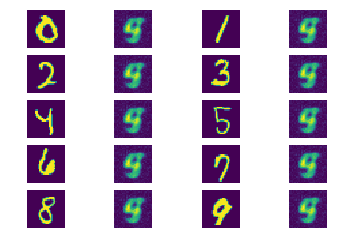

=== Distances ===
0 0 0.1908497686434537
0 1 0.602181387604028
0 2 0.24848854424580932
0 3 0.27687659090869127
0 4 0.32571419561132786
0 5 0.30136334748342636
0 6 0.3020991140298545
0 7 0.31295974739454685
0 8 0.24980786727331578
0 9 0.2864939820840955

1 1 0.3449472238838673
1 2 0.5175728870060294
1 3 0.4809070442568511
1 4 0.4206315211452544
1 5 0.4836812042210251
1 6 0.4745326632589102
1 7 0.42192837894856927
1 8 0.5145248916216195
1 9 0.45906192223355174

2 2 0.24994263401702047
2 3 0.25958134915418923
2 4 0.28181552007086574
2 5 0.28589298312440514
2 6 0.276967085294798
2 7 0.2777889301799238
2 8 0.25006288267541676
2 9 0.2624000551845878

3 3 0.24422062945067882
3 4 0.2638271864209324
3 5 0.28061102781556546
3 6 0.27701641868501903
3 7 0.26074696610867976
3 8 0.2518546394687146
3 9 0.25131167499832807

4 4 0.24819883009046317
4 5 0.29122157217636707
4 6 0.27654199925251305
4 7 0.25010940205939114
4 8 0.27390252536423504
4 9 0.2527365944966674

5 5 0.30417735397294166
5 6 0.299304

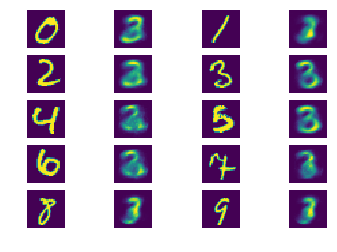

=== Epoch  20  ===
loss:  -0.20584244


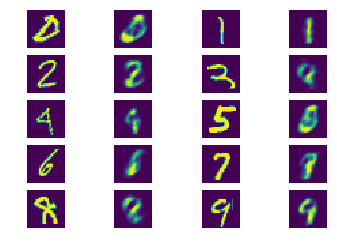

=== Epoch  30  ===
loss:  -0.11047832


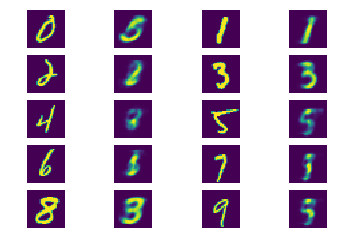

=== Epoch  40  ===
loss:  -0.30779192


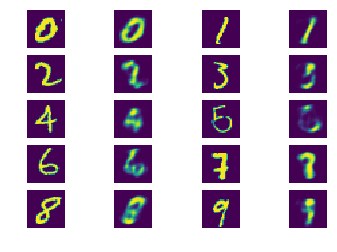

=== Epoch  50  ===
loss:  0.2101673


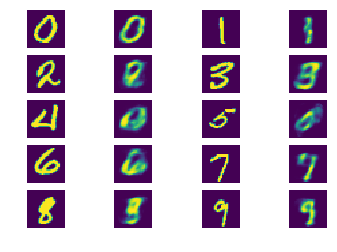

=== Epoch  60  ===
loss:  0.20957804


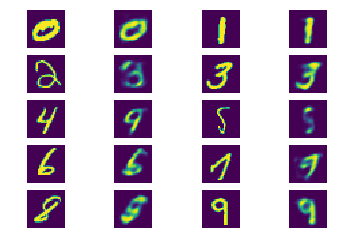

=== Epoch  70  ===
loss:  0.21601787


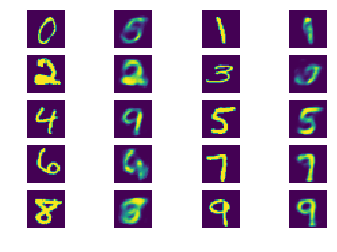

=== Epoch  80  ===
loss:  0.1858377


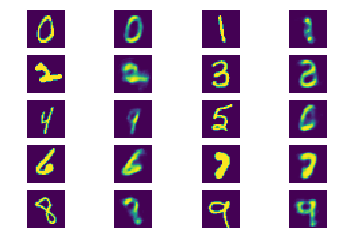

=== Epoch  90  ===
loss:  0.060135856


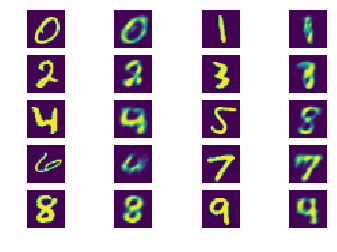

=== Epoch  100  ===
loss:  -0.0029300638


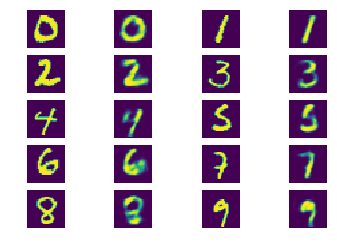

=== Distances ===
0 0 2.714791667723656
0 1 4.469324909281731
0 2 3.633699677312374
0 3 3.6891542360544203
0 4 3.777956237435341
0 5 3.4398885155916212
0 6 3.7030357270479204
0 7 3.7026103274822235
0 8 3.5425048576951026
0 9 3.8419807480573653

1 1 2.692792060416937
1 2 3.832014805531502
1 3 3.8325449417710304
1 4 3.9202151560783385
1 5 4.02058314346075
1 6 3.823942661857605
1 7 3.999498512864113
1 8 3.624483893597126
1 9 3.9945941185355185

2 2 2.9190315613269804
2 3 3.5153917085289956
2 4 3.5989563929915427
2 5 3.612248983311653
2 6 3.3603676399350166
2 7 3.7833720646500586
2 8 3.230681625533104
2 9 3.814319779229164

3 3 2.863552691757679
3 4 3.644596827185154
3 5 3.318084664797783
3 6 3.609930195450783
3 7 3.684506059837341
3 8 3.2217231818675995
3 9 3.6918757125139234

4 4 2.7903716775357723
4 5 3.6086411783456804
4 6 3.5144984640479087
4 7 3.4226090913295746
4 8 3.370974344980717
4 9 2.9878854356050493

5 5 3.115277688872814
5 6 3.4756666941165926
5 7 3.7148923803329468
5 8 3.157

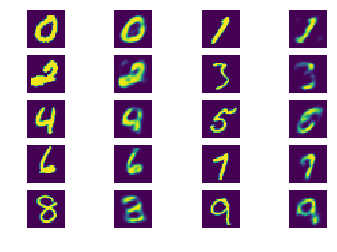

=== Epoch  120  ===
loss:  0.18175736


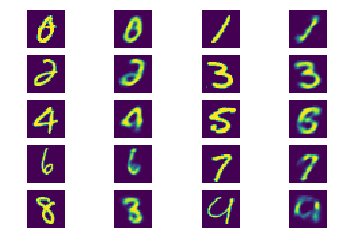

=== Epoch  130  ===
loss:  0.09228552


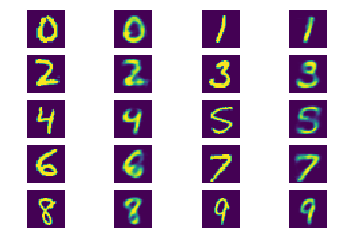

=== Epoch  140  ===
loss:  0.21629807


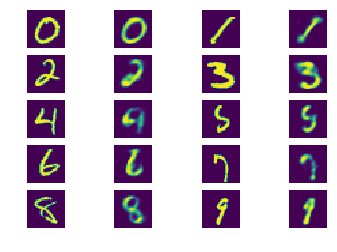

=== Epoch  150  ===
loss:  0.24896033


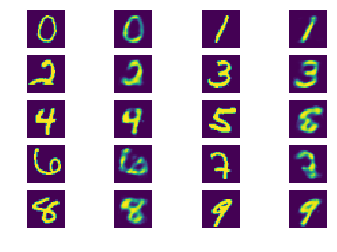

=== Epoch  160  ===
loss:  0.19874461


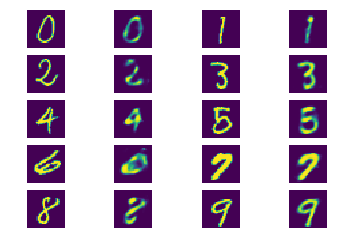

=== Epoch  170  ===
loss:  -0.39487708


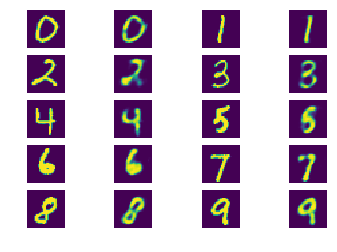

=== Epoch  180  ===
loss:  0.17912337


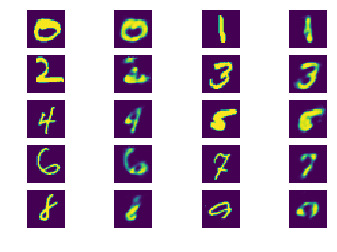

=== Epoch  190  ===
loss:  0.18620889


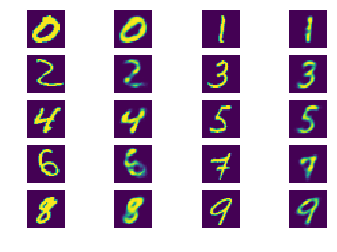

=== Epoch  200  ===
loss:  0.15549186


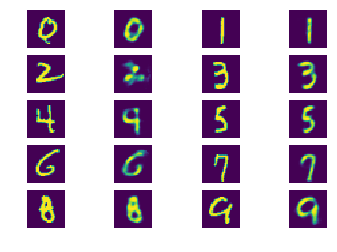

=== Distances ===
0 0 2.4940156628608703
0 1 3.932300157546997
0 2 3.225997600853443
0 3 3.2217359548330307
0 4 3.4254071472406387
0 5 3.0772766221642494
0 6 3.1646524336099624
0 7 3.4747550063490866
0 8 3.2337630345225334
0 9 3.4193430749893188

1 1 2.4339243583261965
1 2 3.566301704967022
1 3 3.594451657271385
1 4 3.493991081035137
1 5 3.642065497612953
1 6 3.5803696717739104
1 7 3.597706926906109
1 8 3.37097029761076
1 9 3.5117947930693627

2 2 2.7492549874544143
2 3 3.1268661165118217
2 4 3.30453327794075
2 5 3.245403833115101
2 6 3.0567317918896677
2 7 3.578523477458954
2 8 3.133989729106426
2 9 3.476783579146862

3 3 2.6090812981247904
3 4 3.3288837284088135
3 5 2.9511194988012313
3 6 3.2481230104804037
3 7 3.431178759074211
3 8 3.0000202484369276
3 9 3.3602554183363913

4 4 2.682094956076145
4 5 3.2874538442850114
4 6 3.183190133464336
4 7 3.238601099920273
4 8 3.1744931523203848
4 9 2.875445030301809

5 5 2.8238408435583113
5 6 3.097424169945717
5 7 3.4642694968938827
5 8 2.996

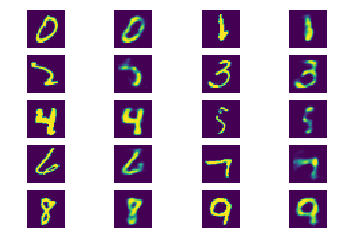

=== Epoch  220  ===
loss:  0.19761258


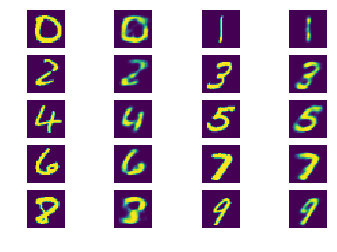

=== Epoch  230  ===
loss:  0.19784921


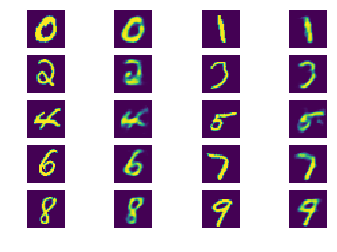

=== Epoch  240  ===
loss:  0.1814076


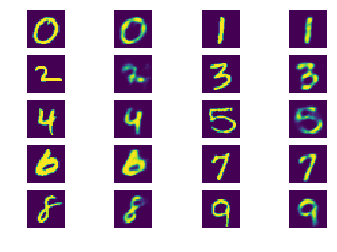

=== Epoch  250  ===
loss:  -0.31412074


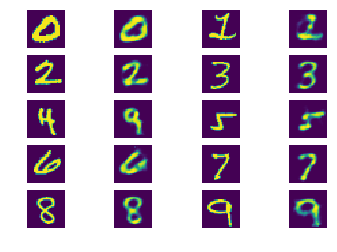

=== Epoch  260  ===
loss:  -0.31937698


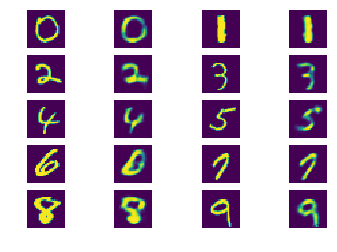

=== Epoch  270  ===
loss:  0.21940234


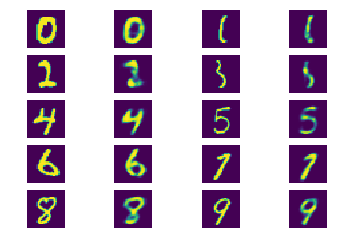

=== Epoch  280  ===
loss:  0.1787174


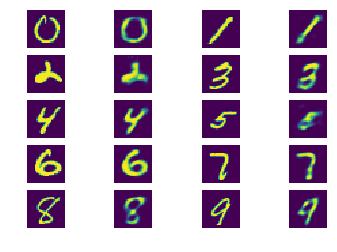

=== Epoch  290  ===
loss:  0.16928405


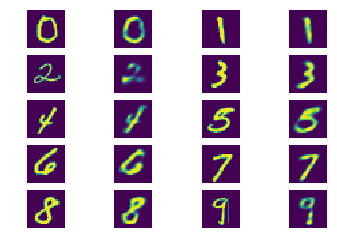

=== Epoch  300  ===
loss:  0.19577621


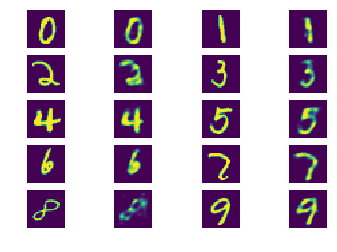

=== Distances ===
0 0 2.3321392600417137
0 1 3.571771116900444
0 2 3.019115378010273
0 3 2.975205361711979
0 4 3.2780567626595496
0 5 2.788395787668228
0 6 2.9765465783596037
0 7 3.22227002658844
0 8 2.9254434672117235
0 9 3.2234463683009147

1 1 2.1484696647644044
1 2 3.180679751431942
1 3 3.177743605017662
1 4 3.2296324276685713
1 5 3.2167374900102614
1 6 3.3130447714805604
1 7 3.2852502310693263
1 8 2.993908528983593
1 9 3.2274554905653

2 2 2.5723881788730623
2 3 2.854250999546051
2 4 3.1855580723404886
2 5 2.960668127787113
2 6 2.92910796854496
2 7 3.372214412248135
2 8 2.8403134419560434
2 9 3.2999921118617057

3 3 2.393492149078846
3 4 3.1613241732239725
3 5 2.6804585701584815
3 6 3.0927230447292327
3 7 3.1793369224071504
3 8 2.689398382985592
3 9 3.181267820620537

4 4 2.560350522041321
4 5 3.117588903439045
4 6 3.18496014829874
4 7 3.0921812510609628
4 8 2.9791994724631308
4 9 2.7273893010616304

5 5 2.52295273052454
5 6 2.9240359386205674
5 7 3.1927664080142977
5 8 2.69245217

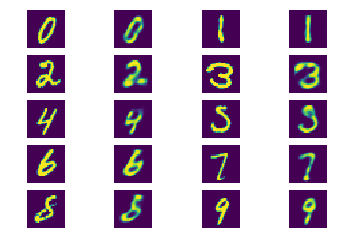

=== Epoch  320  ===
loss:  0.05161187


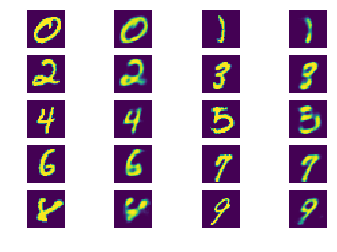

=== Epoch  330  ===
loss:  -0.1089668


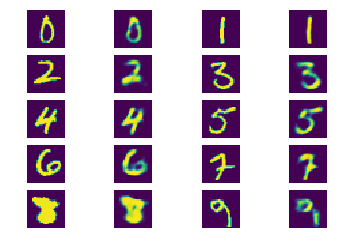

=== Epoch  340  ===
loss:  0.0843765


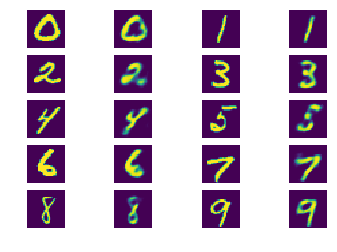

=== Epoch  350  ===
loss:  0.1800677


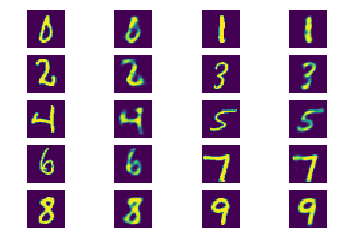

=== Epoch  360  ===
loss:  -0.24567527


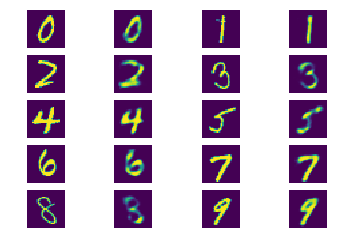

=== Epoch  370  ===
loss:  -0.20791143


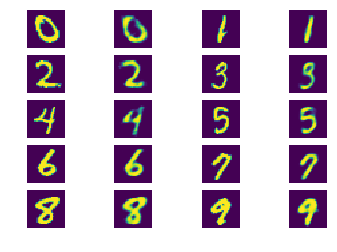

=== Epoch  380  ===
loss:  0.06328266


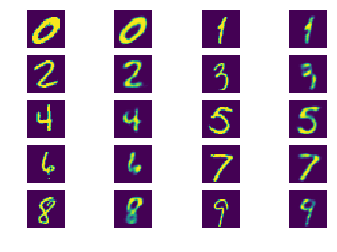

=== Epoch  390  ===
loss:  0.21387365


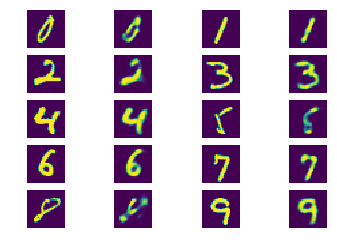

=== Epoch  400  ===
loss:  0.22230443


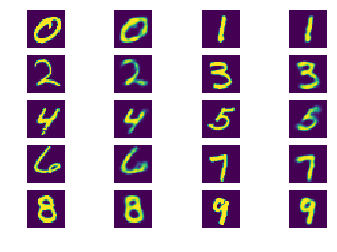

=== Distances ===
0 0 2.1400879384875298
0 1 3.6156055060863497
0 2 2.8393360078573227
0 3 2.776036533391476
0 4 2.965883131980896
0 5 2.6254139856815337
0 6 2.888746219277382
0 7 3.036443271291256
0 8 2.801887768089771
0 9 2.87910534286499

1 1 2.214485556399822
1 2 3.208577294743061
1 3 3.1915937542438506
1 4 3.1648129173278807
1 5 3.2937173993349074
1 6 3.356550566339493
1 7 3.3030701849102972
1 8 3.037277982532978
1 9 3.155233555138111

2 2 2.50121386756897
2 3 2.7523110411047935
2 4 2.926208205115795
2 5 2.853770020413399
2 6 2.9493509182572364
2 7 3.1627347155451773
2 8 2.7691639277577402
2 9 2.968736235618591

3 3 2.2957081262111663
3 4 2.858268336248398
3 5 2.5814534118890764
3 6 3.056695168054104
3 7 2.9836181752324102
3 8 2.6022944549441336
3 9 2.8347128224134446

4 4 2.3329719657719137
4 5 2.832780367743969
4 6 2.974895113539696
4 7 2.8540646589279173
4 8 2.730089885175228
4 9 2.442326752012968

5 5 2.430265172672272
5 6 2.886401481235027
5 7 3.0276404420614242
5 8 2.6001195

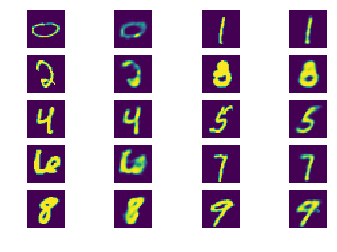

=== Epoch  420  ===
loss:  0.22335914


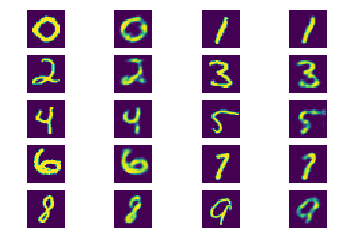

=== Epoch  430  ===
loss:  0.23077618


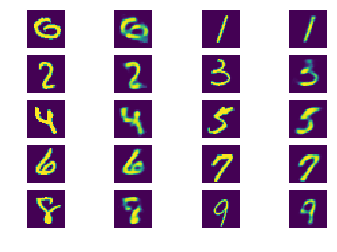

=== Epoch  440  ===
loss:  -0.7475382


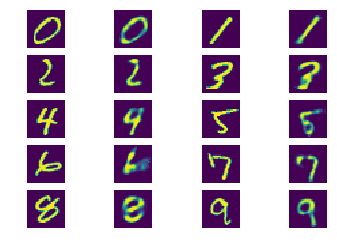

=== Epoch  450  ===
loss:  0.17645171


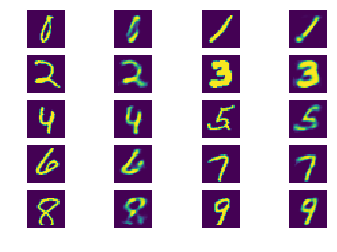

=== Epoch  460  ===
loss:  0.1771842


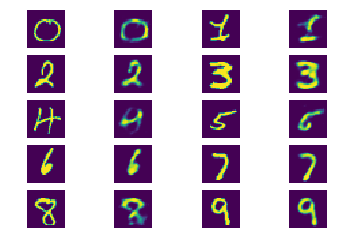

=== Epoch  470  ===
loss:  0.124838896


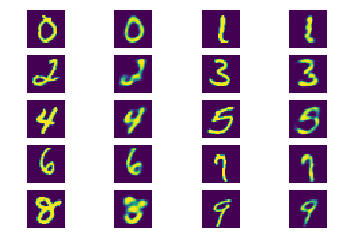

=== Epoch  480  ===
loss:  -0.3072055


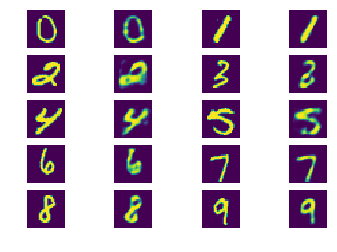

=== Epoch  490  ===
loss:  -0.13199261


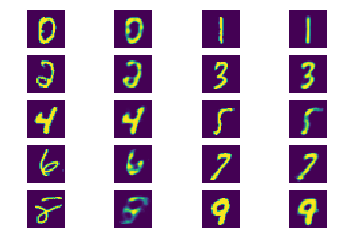

=== Epoch  500  ===
loss:  0.17294729


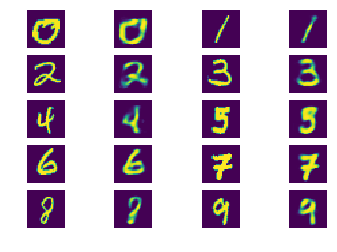

=== Distances ===
0 0 2.0605035738945006
0 1 3.3704321206331254
0 2 2.692767580640316
0 3 2.6168832886457443
0 4 3.0105426859021187
0 5 2.526829673564434
0 6 2.6131793906569483
0 7 3.0008580634832382
0 8 2.6855761398911477
0 9 2.9038868592619895

1 1 2.008138078510761
1 2 2.9615222494363787
1 3 2.9818289307951926
1 4 3.000095700144768
1 5 3.022278902065754
1 6 3.0554098824501037
1 7 3.0922826697528363
1 8 2.7934821240305903
1 9 2.9930491711258886

2 2 2.348501922893524
2 3 2.610978510403633
2 4 2.928760747694969
2 5 2.70534566886425
2 6 2.5964713075637817
2 7 3.105909164226055
2 8 2.6097399748444556
2 9 2.9546951303720475

3 3 2.14982383351326
3 4 2.872654644048214
3 5 2.442361745941639
3 6 2.738918795692921
3 7 2.9245658932328222
3 8 2.4771962183356284
3 9 2.8229116298675536

4 4 2.3750184148609637
4 5 2.8644412420630454
4 6 2.8680467221736907
4 7 2.829830976843834
4 8 2.7302436191797255
4 9 2.482082560175657

5 5 2.3462522802472114
5 6 2.6084490372896196
5 7 2.986334053134918
5 8 2.4

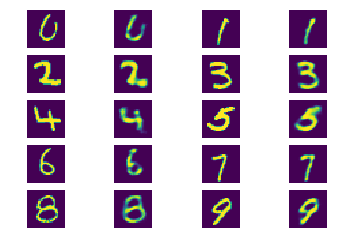

=== Epoch  520  ===
loss:  0.18036501


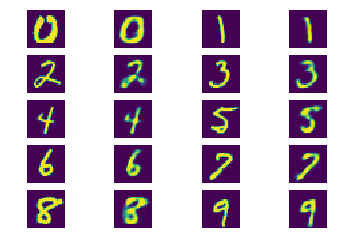

=== Epoch  530  ===
loss:  -0.24163467


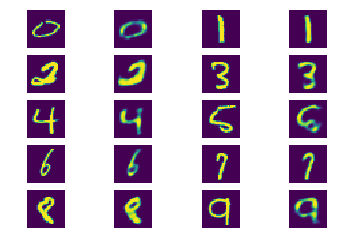

=== Epoch  540  ===
loss:  0.18607052


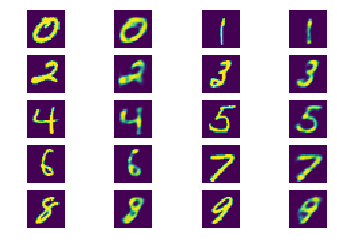

=== Epoch  550  ===
loss:  0.23888865


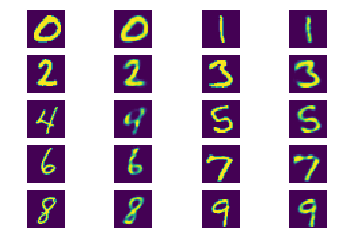

=== Epoch  560  ===
loss:  0.19125755


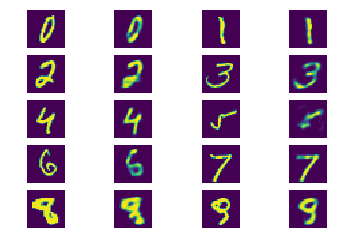

=== Epoch  570  ===
loss:  -0.030500412


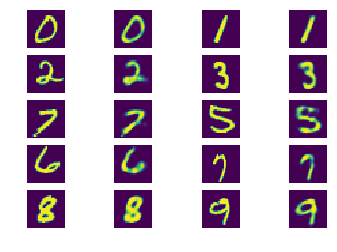

=== Epoch  580  ===
loss:  -0.41027525


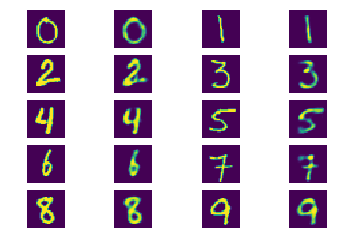

=== Epoch  590  ===
loss:  0.035243787


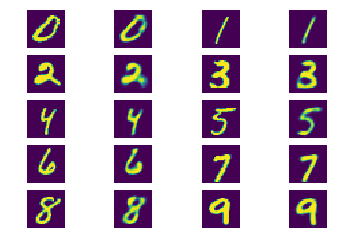

=== Epoch  600  ===
loss:  -0.6952743


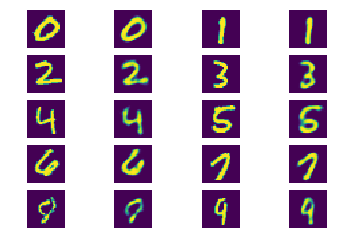

=== Distances ===
0 0 2.2504766669869425
0 1 3.5973831944942476
0 2 2.848308218693733
0 3 2.7789352799534797
0 4 3.071479860794544
0 5 2.69813488843441
0 6 2.8056069007754325
0 7 3.0591806830763817
0 8 2.8745290403485297
0 9 2.9694277309298514

1 1 2.249595554882288
1 2 3.1819303690314293
1 3 3.1846341722369194
1 4 3.102651860487461
1 5 3.2162300705313682
1 6 3.1980448411107063
1 7 3.1925697378873825
1 8 3.009822431588173
1 9 3.092526712846756

2 2 2.385984360289574
2 3 2.6621192693710327
2 4 2.9181803802371027
2 5 2.7671096710681917
2 6 2.6840011045217516
2 7 3.140973614859581
2 8 2.73461451253891
2 9 2.9648674775481223

3 3 2.2294641846060754
3 4 2.8787801010727883
3 5 2.527977488732338
3 6 2.8271526329755785
3 7 2.9450587386012077
3 8 2.5808727321147917
3 9 2.829312370467186

4 4 2.337281256425381
4 5 2.848860903906822
4 6 2.8563772039055824
4 7 2.8265657259225847
4 8 2.7520222932219505
4 9 2.461846938967705

5 5 2.4309862382769585
5 6 2.706269421982765
5 7 2.9940915279984472
5 8 2.

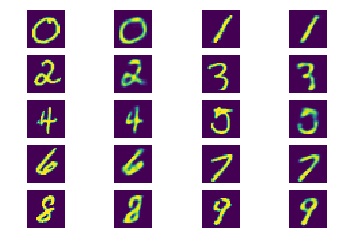

=== Epoch  620  ===
loss:  0.10154187


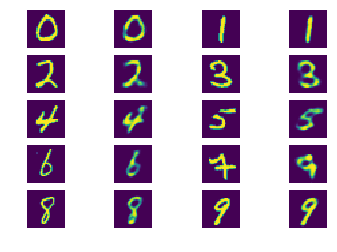

=== Epoch  630  ===
loss:  0.21790929


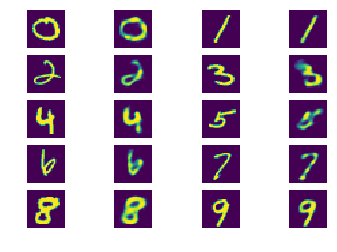

=== Epoch  640  ===
loss:  0.21245208


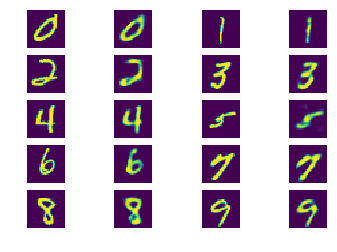

=== Epoch  650  ===
loss:  0.069661364


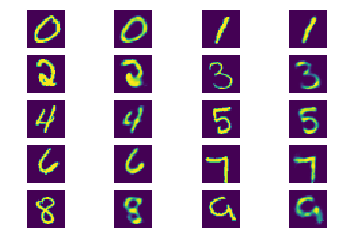

=== Epoch  660  ===
loss:  0.18069547


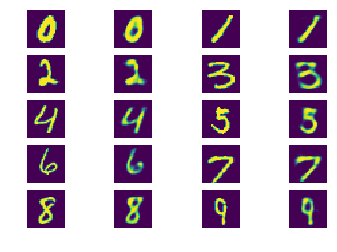

=== Epoch  670  ===
loss:  0.22028661


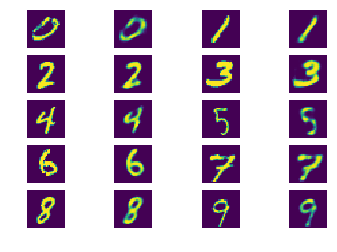

=== Epoch  680  ===
loss:  -0.19041091


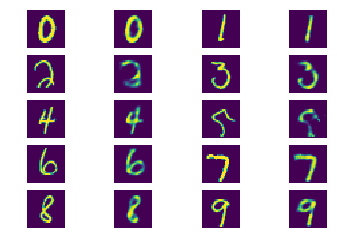

=== Epoch  690  ===
loss:  0.23780638


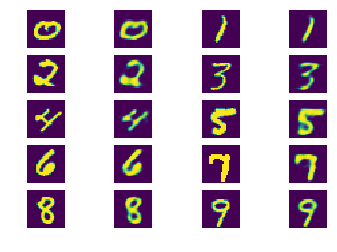

=== Epoch  700  ===
loss:  0.17774579


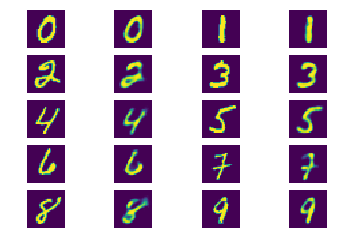

=== Distances ===
0 0 1.9609339024424552
0 1 3.2559923194766043
0 2 2.6242511902689936
0 3 2.523324438881874
0 4 2.883263006401062
0 5 2.441008627474308
0 6 2.5369128157138823
0 7 2.9666638403654098
0 8 2.643020423567295
0 9 2.8701886075615883

1 1 2.008926778835058
1 2 2.9415795037984847
1 3 2.918012240099907
1 4 2.909922773516178
1 5 2.9257248081207274
1 6 2.941691685259342
1 7 3.0364852370381357
1 8 2.707690754377842
1 9 2.9368789939880373

2 2 2.313425930583477
2 3 2.54639823025465
2 4 2.8826783755660057
2 5 2.636294362616539
2 6 2.5509404987454416
2 7 3.1156938712835314
2 8 2.644632079851627
2 9 3.0012351551651957

3 3 2.1290785093426705
3 4 2.8281496325612068
3 5 2.3801316163539887
3 6 2.6541552612423898
3 7 2.951302604115009
3 8 2.473163914883137
3 9 2.8692899527668954

4 4 2.368459433114529
4 5 2.7889646165728568
4 6 2.7638542197465896
4 7 2.821574202656746
4 8 2.7111996247887613
4 9 2.508764386487007

5 5 2.2827757061481475
5 6 2.538390083646774
5 7 2.981061229431629
5 8 2.454

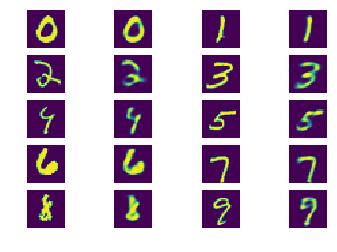

=== Epoch  720  ===
loss:  -0.030380473


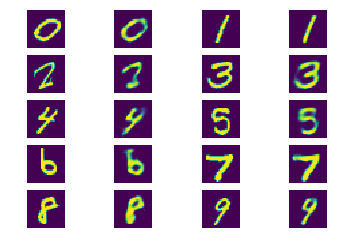

=== Epoch  730  ===
loss:  0.2172533


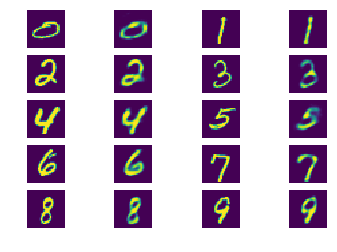

=== Epoch  740  ===
loss:  0.20116413


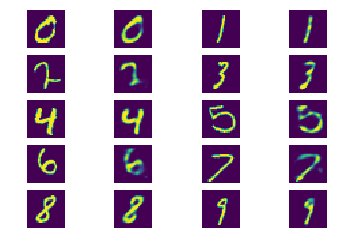

=== Epoch  750  ===
loss:  0.18568823


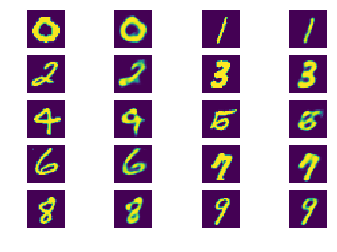

=== Epoch  760  ===
loss:  0.1929869


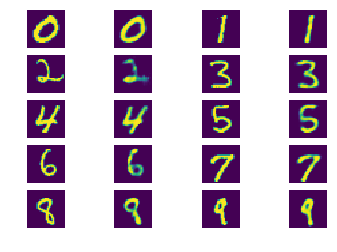

=== Epoch  770  ===
loss:  0.22824264


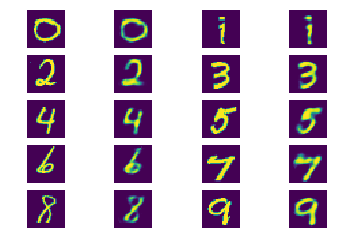

=== Epoch  780  ===
loss:  0.16874318


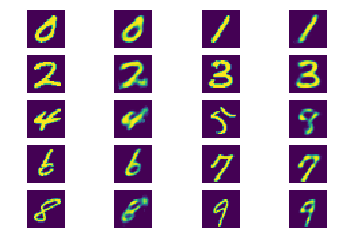

=== Epoch  790  ===
loss:  0.19065656


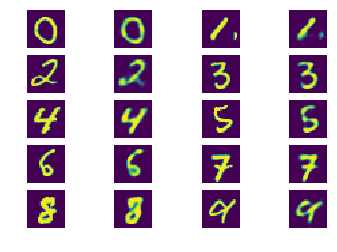

=== Epoch  800  ===
loss:  0.007698104


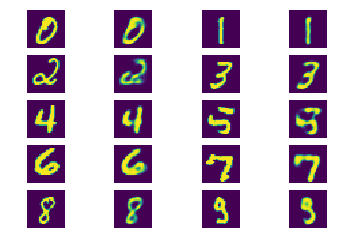

=== Distances ===
0 0 2.050874773466587
0 1 3.3439302246928215
0 2 2.678860728991032
0 3 2.5840987164616585
0 4 2.913864738929272
0 5 2.5124265080690384
0 6 2.6363940519213678
0 7 2.8595156742572785
0 8 2.685497009205818
0 9 2.8201736717104913

1 1 2.095157373958826
1 2 2.952619420647621
1 3 2.9206216544985772
1 4 2.895674019062519
1 5 2.9419111431598663
1 6 2.9543590646624565
1 7 2.9766759359717367
1 8 2.7374536507248877
1 9 2.873974130988121

2 2 2.2703657911896706
2 3 2.492715277171135
2 4 2.815839669883251
2 5 2.6023360090494156
2 6 2.5777800855398176
2 7 2.936093958592415
2 8 2.5750039011001586
2 9 2.835921554744244

3 3 2.0879373114585875
3 4 2.7590467537403107
3 5 2.3529987670302392
3 6 2.659551800894737
3 7 2.7877409752249718
3 8 2.4121338613152505
3 9 2.7168514411449434

4 4 2.2474858153522015
4 5 2.7169365134596823
4 6 2.7439610113859176
4 7 2.6456531586885452
4 8 2.634192041409016
4 9 2.3429416357040407

5 5 2.269063619196415
5 6 2.556076835179329
5 7 2.8013767770171167
5 8 

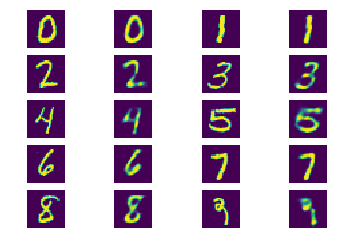

=== Epoch  820  ===
loss:  0.2081095


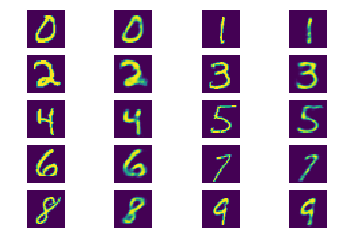

=== Epoch  830  ===
loss:  0.20321825


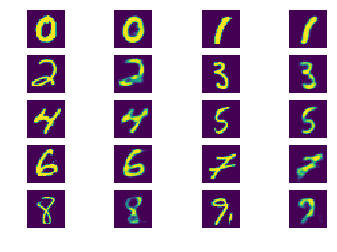

=== Epoch  840  ===
loss:  0.15695664


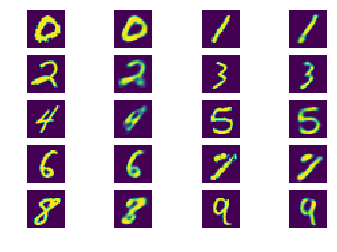

=== Epoch  850  ===
loss:  0.1789377


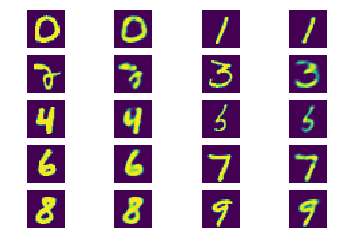

=== Epoch  860  ===
loss:  -0.37221697


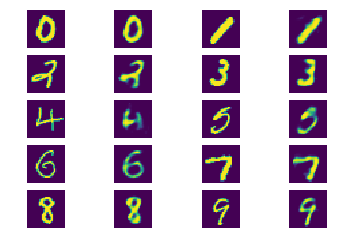

=== Epoch  870  ===
loss:  -0.2909222


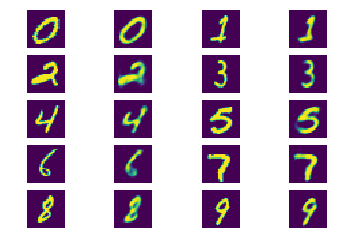

KeyboardInterrupt: 

In [9]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(total_epochs):
        class1 = random.randint(0, 9)
        class2 = random.randint(0, 9)
        while class1 == class2:
            class1 = random.randint(0, 9)
            class2 = random.randint(0, 9)

        data1 = np.copy(train_x_per_class[class1])
        data2 = np.copy(train_x_per_class[class2])
        np.random.shuffle(data1)
        np.random.shuffle(data2)

        total_batchs = int(min(len(data1), len(data2)) / batch_size)
        for batch in range(total_batchs):
            batch_x1 = data1[(batch * batch_size):((batch + 1) * batch_size)]
            batch_x2 = data2[(batch * batch_size):((batch + 1) * batch_size)]

            sess.run(train, feed_dict={X1: batch_x1, X2: batch_x2})

        if epoch % 10 == 0:
            print("=== Epoch ", epoch, " ===")
            loss_r = sess.run(loss, feed_dict={X1: batch_x1, X2: batch_x2})
            print("loss: ", loss_r)
            
            x_list = []
            for cls in range(10):
                candidate = train_x_per_class[cls]
                x_list.append(candidate[random.randint(0, len(candidate) - 1)])
            x_list = np.asarray(x_list)
            
            gen_list = sess.run(dec1, feed_dict={X1: x_list})
            origimg = x_list.reshape([-1, 28, 28])
            genimg = gen_list.reshape([-1, 28, 28])
            
            _, axes = plt.subplots(5, 4)
            for cls in range(10):
                axes[cls // 2, (cls % 2) * 2 + 0].imshow(origimg[cls])
                axes[cls // 2, (cls % 2) * 2 + 0].axis('off')
                axes[cls // 2, (cls % 2) * 2 + 1].imshow(genimg[cls])
                axes[cls // 2, (cls % 2) * 2 + 1].axis('off')
            plt.show()

        if epoch % 100 == 0:
            print('=== Distances ===')
            for i in range(10):
                for j in range(i, 10):
                    gen1, gen2 = sess.run(
                        [enc1, enc2],
                        feed_dict={X1: train_x_per_class[i][0:100], X2: train_x_per_class[j][0:100]}
                    )
                    print(i, j, dist(gen1, gen2))
                print()